In [17]:
import numpy as np
from boost import *
from utils import *

# Data
fsw = 40E3
Ts = 1/fsw
Vd = 6
Vo = 15
Vo_ripple = 0.07
Delta_Vo = Vo*Vo_ripple
VGG = 18

L = 220E-6
L_tol = 0.1
L_Q = 20
R_L = 2*np.pi*fsw*L/L_Q
C = 10E-6
ESR = 1

# Calculamos D inicial
D = 1 - Vd/Vo
R = 500
Io = Vo/R

# Averiguamos si estamos en CCM o DCM
Iob = Vo*Ts*((1-D)**2)*D / (2*L)
print('Iob = ' + to_unit(Iob) + 'A')
print('')

if Io >= Iob:
    # Estamos en CCM
    print("Boost CCM")
    print(f'D = {D:.2g}')

    Ix = Io/(1-D)
    print('Ix = ' + to_unit(Ix) + 'A')
    
    Delta_Il = (Vd/L)*D*Ts
    print('Delta_IL = ' + to_unit(Delta_Il) + 'A')
    
    IL_max = Ix + Delta_Il/2
    print('IL_max = ' + to_unit(IL_max) + 'A')

    # Calculo Delta Q
    Delta_Q = CCM_get_Delta_Q(Vd, Vo, D, Ts, L, Io)

else:
    # Estamos en DCM
    print("Boost DCM")
    
    # Tiempos
    D = np.sqrt(( 2*L*Io / (Vd*Ts)) * (Vo/Vd - 1))
    Delta_1 = 2*L*Io / (Vd*D*Ts)
    print(f'D = {D:.2g}')
    print(f'Delta_1 = {Delta_1:.2g}')
    
    # Corrientes
    Delta_Il = (Vd/L)*D*Ts
    print('Delta_IL = ' + to_unit(Delta_Il) + 'A')
    IL_max = Delta_Il
    print('IL_max = ' + to_unit(IL_max) + 'A')
    
	# Calculo Delta Q
    Delta_Q = DCM_get_Delta_Q(Vd, Vo, D, Ts, L, Io)
    
Delta_Vc = Delta_Vo - Delta_Il*ESR

Iob = 81.8mA

Boost DCM
D = 0.36
Delta_1 = 0.24
Delta_IL = 248mA
IL_max = 248mA


In [18]:
import math
import numpy as np
from utils import *
import matplotlib.pyplot as plt

def get_sim_data(file,j):
    FILE_NAME = file
    with open(FILE_NAME, "r") as f:
        first_row = f.readline()    
    my_data = np.genfromtxt(FILE_NAME, delimiter='\t')
    t = []
    y = []
    for i in range(len(my_data)):
        # check if number
        x1 = float(my_data[i][0])
        y1 = float(my_data[i][j])	
        if not (math.isnan(x1) or math.isnan(y1)):
            t.append(x1)
            y.append(y1)
    return t, y



def plot_sim_vs_teo(ax,t, x_sim, x_teo, D, Ts, Delta_1=0):

    p, e = get_exp(t[-1])
    ax.plot(np.multiply(t,1000**(-e)),x_sim)
    ax.plot(np.multiply(t,1000**(-e)), x_teo)
    ax.set_xlabel('t [' + get_unit_prefix(t[-1]) + 's]')
    ax.grid()

In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt
from utils import *

N_IC = 1
N_ID = 2
N_IO = 4
N_IL = 3
N_Isw = 5

N_VC = 1
N_Vdd = 2
N_VO = 3
N_Vsw = 4

### Inductor

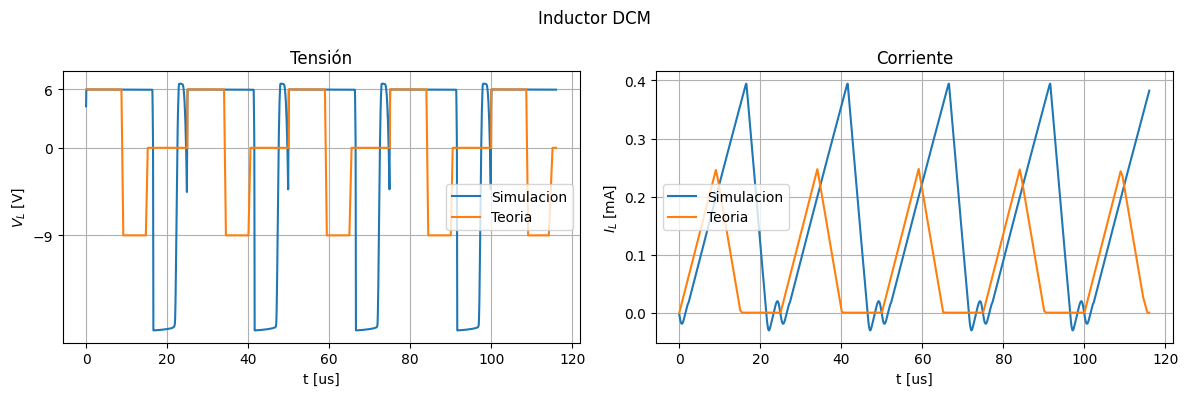

In [20]:
fileI = "..\Simulaciones\I_DCM.txt"
t_i, i = get_sim_data(fileI,N_IL)

fileV = "..\Simulaciones\V_DCM.txt"
t, vdd = get_sim_data(fileV,N_Vdd)
tv, vsw = get_sim_data(fileV,N_Vsw)

VL = [get_VL(Vd, Vo, L, Ts, Io, ti) for ti in t]
IL = [get_IL(Vd, Vo, L, Ts, Io, ti) for ti in t_i]


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Inductor DCM')

# Plot VL
plot_sim_vs_teo(ax[0],tv,np.subtract(vdd,vsw), VL, D, Ts)
ax[0].set_title('Tensión')
ax[0].set_ylabel('$V_L$ [' + get_unit_prefix(max(VL)) + 'V]')
ax[0].set_yticks([Vd, 0, -(Vo-Vd)])
ax[0].legend(['Simulacion','Teoria'])

# Plot IL
plot_sim_vs_teo(ax[1],t_i,i, IL, D, Ts)
ax[1].set_title('Corriente')
ax[1].set_ylabel('$I_L$ [' + get_unit_prefix(max(IL)) + 'A]')
ax[1].legend(['Simulacion','Teoria'])


fig.tight_layout()

### Switch

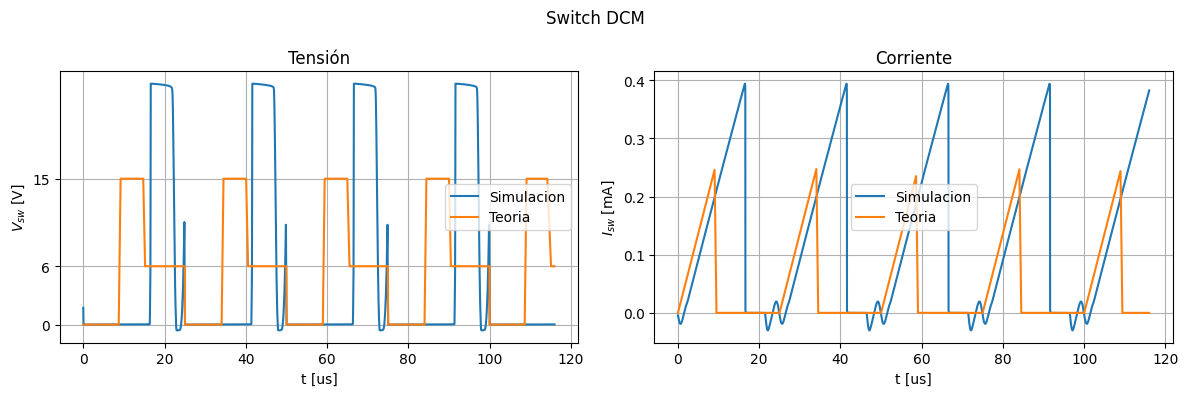

In [21]:
t_i, i = get_sim_data(fileI,N_Isw)

tv, vsw = get_sim_data(fileV,N_Vsw)

Vsw = [get_Vsw(Vd, Vo, L, Ts, Io, ti) for ti in tv]
Isw = [get_Isw(Vd, Vo, L, Ts, Io, ti) for ti in t_i]


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Switch DCM')

# Plot VL
plot_sim_vs_teo(ax[0],tv,vsw, Vsw, D, Ts)
ax[0].set_title('Tensión')
ax[0].set_ylabel('$V_{sw}$ [' + get_unit_prefix(max(Vsw)) + 'V]')
ax[0].set_yticks([0,Vd, Vo])
ax[0].legend(['Simulacion','Teoria'])

# Plot IL
plot_sim_vs_teo(ax[1],t_i,i, Isw, D, Ts)
ax[1].set_title('Corriente')
ax[1].set_ylabel('$I_{sw}$ [' + get_unit_prefix(max(Isw)) + 'A]')
ax[1].legend(['Simulacion','Teoria'])

fig.tight_layout()

### Diodo

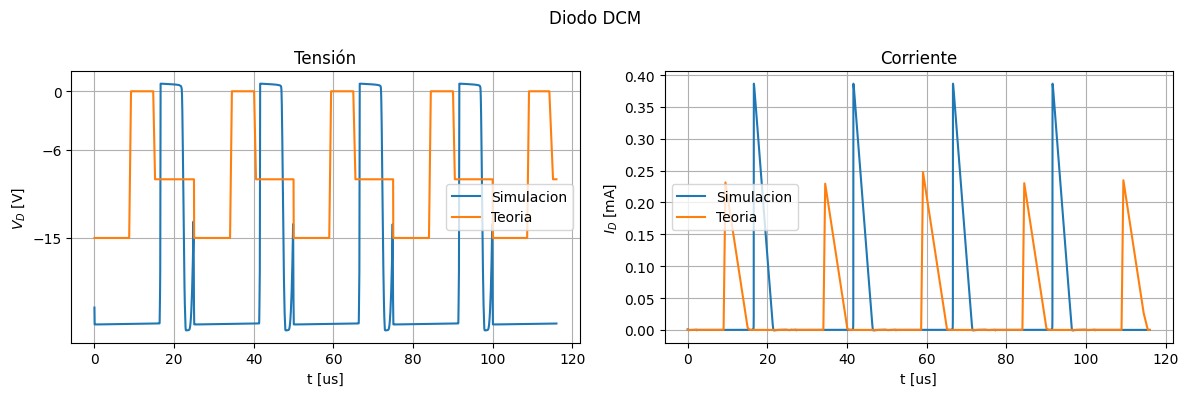

In [22]:
t_i, i = get_sim_data(fileI,N_ID)

t, vo = get_sim_data(fileV,N_VO)
tv, vsw = get_sim_data(fileV,N_Vsw)

VD = [get_VD(Vd, Vo, L, Ts, Io, ti) for ti in t]
ID = [get_ID(Vd, Vo, L, Ts, Io, ti) for ti in t_i]


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Diodo DCM')

# Plot VL
plot_sim_vs_teo(ax[0],tv,np.subtract(vsw,vo), np.multiply(VD,-1), D, Ts)
ax[0].set_title('Tensión')
ax[0].set_ylabel('$V_D$ [' + get_unit_prefix(max(VD)) + 'V]')
ax[0].set_yticks([-Vo,-Vd, 0])
ax[0].legend(['Simulacion','Teoria'])

# Plot IL
plot_sim_vs_teo(ax[1],t_i,i, ID, D, Ts)
ax[1].set_title('Corriente')
ax[1].set_ylabel('$I_D$ [' + get_unit_prefix(max(ID)) + 'A]')
ax[1].legend(['Simulacion','Teoria'])

fig.tight_layout()

### Capacitor

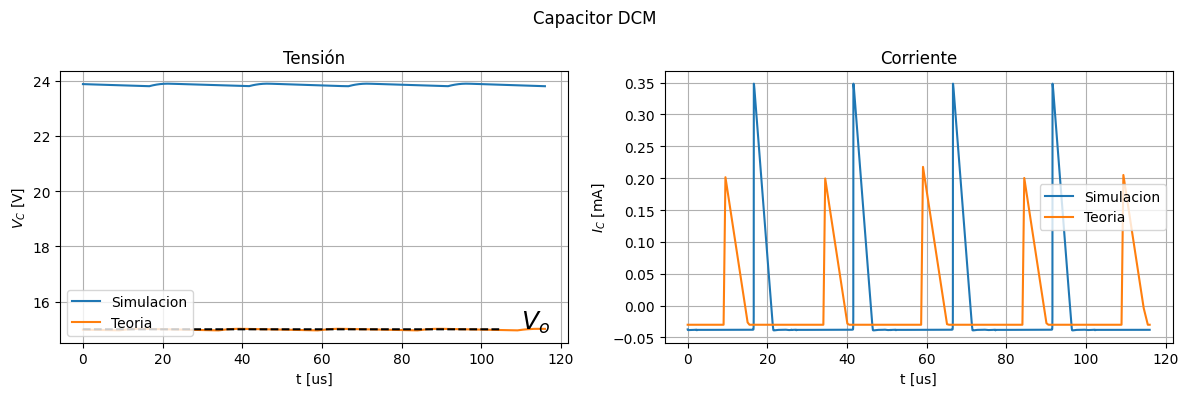

In [23]:
t_i, i = get_sim_data(fileI,N_IC)

tv, vc = get_sim_data(fileV,N_VC)

VC = [get_VC(Vd, Vo, L,C, Ts, Io, ti) for ti in tv]
VC = VC + (-np.mean(VC[0:len(tv)]) + Vo)*np.ones_like(VC)
IC = [get_IC(Vd, Vo, L, Ts, Io, ti) for ti in t_i]


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Capacitor DCM')

# Plot VL
plot_sim_vs_teo(ax[0],tv,vc, VC, D, Ts)
ax[0].set_title('Tensión')
ax[0].set_ylabel('$V_C$ [' + get_unit_prefix(max(VC)) + 'V]')
p, e = get_exp(t[-1])
t=np.multiply(t,1000**(-e))
ax[0].plot(t[0:-50], Vo*np.ones_like(t[0:-50]), color='black', linestyle='--')
ax[0].annotate('$V_o$', xy=(t[-40], Vo), xytext=(t[-40], Vo), color='black', fontsize=18)
ax[0].legend(['Simulacion','Teoria'],loc='lower left')

# Plot IL
plot_sim_vs_teo(ax[1],t_i,i, IC, D, Ts)
ax[1].set_title('Corriente')
ax[1].set_ylabel('$I_C$ [' + get_unit_prefix(max(IC)) + 'A]')
ax[1].legend(['Simulacion','Teoria'])

#ax[0].set_yticks([14,15,16,17])

fig.tight_layout()

### Salida

ValueError: x and y must have same first dimension, but have shapes (1742,) and (1,)

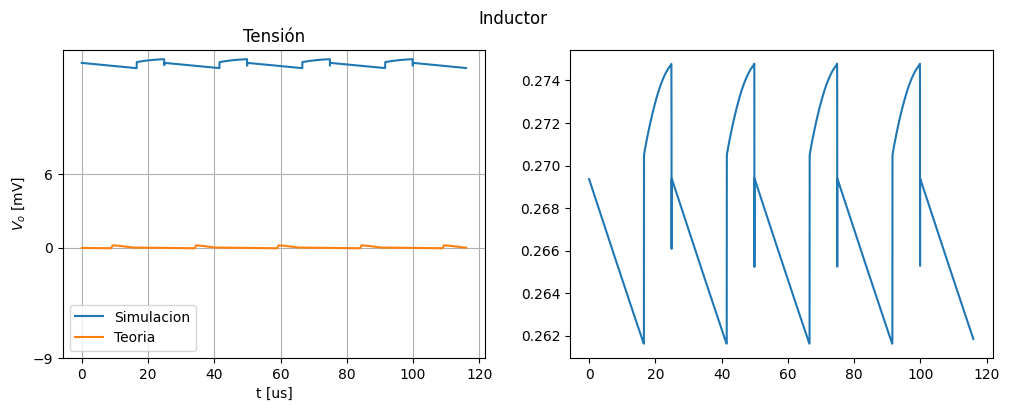

In [24]:
fileI = "..\Simulaciones\I_CCM.txt"
t_i, i = get_sim_data(fileI,N_IO)

fileV = "..\Simulaciones\V_CCM.txt"
tv, vo = get_sim_data(fileV,N_VO)

VO = [get_VO(Vd, Vo, L,C,ESR, Ts, Io, ti) for ti in tv]
IO = 318.2E-3


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Inductor')

# Plot VL
plot_sim_vs_teo(ax[0],tv,vo, VO, D, Ts)
ax[0].set_title('Tensión')
ax[0].set_ylabel('$V_o$ [' + get_unit_prefix(max(VO)) + 'V]')
ax[0].set_yticks([Vd, 0, -(Vo-Vd)])
ax[0].legend(['Simulacion','Teoria'])

# Plot IL
plot_sim_vs_teo(ax[1],t_i,i, IO, D, Ts)
ax[1].set_title('Corriente')
ax[1].set_ylabel('$I_o$ [' + get_unit_prefix(max(IO)) + 'A]')
ax[1].legend(['Simulacion','Teoria']) 